In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

sys.path.append("../Shared/")
from DataService import DataService

/tmp/ipykernel_684968/4293096832.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-07-07 19:03:29.617147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 19:03:30.107493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# fetch data from db

In [2]:
# function to update logs
def updateLog(fileName: str, message: str) -> None:
    try:
        if fileName is not None:
            with open(fileName, "a") as log:
                log.write(message + "\n")
    except Exception as e:
        print(message)

In [3]:
LOG_FILE = "/data/pull_moisture.log"

load_dotenv()
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

In [4]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    updateLog(LOG_FILE, "Missing database credentials")
    raise ValueError("Environment variables are not set")
else:
    # connicting to database
    db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
    conn = db.connect()

In [5]:
# pulling soil moisture data
query = sq.text("select * FROM public.agg_soil_moisture")
sm_df = pd.read_sql(query, conn)

In [6]:
sm_df.drop(columns=["index", "cr_num", "month", "day"], inplace=True)
sm_df.head()
# sm_df.duplicated().sum() # 0
# print(sm_df.shape) #117221

,year,district,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1978,4612,0.165900,0.418710,0.237053
1,1978,4740,0.127140,0.207248,0.163722
2,1978,4741,0.153398,0.215304,0.170989
3,1978,4770,0.140772,0.186390,0.152211
4,1978,4771,0.116810,0.116810,0.116810


In [7]:
sm_df = sm_df.drop_duplicates()

In [8]:
# pull ergot data
query = sq.text("select * FROM public.agg_ergot_samples")
ergot_df = pd.read_sql(query, conn)

In [9]:
ergot_df.shape

(1092, 13)

In [10]:
ergot_df.sample(5)

,year,district,percnt_true,has_ergot,sum_severity,present_prev1,present_prev2,present_prev3,present_in_neighbor,severity_prev1,severity_prev2,severity_prev3,severity_in_neighbor
340,2003,4770,0.000000,False,0.00,False,False,True,True,0.000000,0.000000,0.022989,0.069620
301,2002,4770,0.000000,False,0.00,False,True,True,True,0.000000,0.022989,0.105611,0.010127
220,2000,4733,0.076923,True,0.04,True,False,False,True,0.100559,0.000000,0.000000,0.038462
198,2000,4840,0.017094,True,0.74,True,True,True,True,0.081996,0.004739,0.005824,0.019355
537,2008,4751,0.421053,True,2.25,False,True,True,True,0.000000,0.033333,0.080882,0.234139


In [11]:
ergot_df["has_ergot"].value_counts()

True     881
False    211
Name: has_ergot, dtype: int64

In [12]:
ergot_df.drop(columns=["sum_severity", "present_in_neighbor", "severity_in_neighbor", "percnt_true"], inplace=True)

In [13]:
ergot_df.duplicated().sum()

0

In [14]:
ergot_df = ergot_df.drop_duplicates()

In [15]:
ergot_df.sample(5)

,year,district,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3
74,1996,4771,False,False,False,False,0.000000,0.000000,0.000000
332,2003,4720,True,True,True,True,0.047059,0.127660,0.040000
659,2011,4771,True,True,True,True,0.190083,0.979592,0.229008
79,1997,4820,False,True,False,False,0.000966,0.000000,0.000000
110,1997,4780,True,True,True,False,0.002070,0.002703,0.000000


In [16]:
ergot_df.shape

(1092, 9)

In [17]:
# pull weather data
# in case reading csv
weather_df = pd.read_csv("data/aggregatedDly.csv")
weather_df.shape

(1064, 5478)

In [18]:
weather_df

,Unnamed: 0,year,district,01-01:max_temp,01-01:min_temp,01-01:mean_temp,01-01:min_total_rain,01-01:max_total_rain,01-01:mean_total_rain,01-01:min_total_snow,...,12-31:mean_total_rain,12-31:min_total_snow,12-31:max_total_snow,12-31:mean_total_snow,12-31:min_total_precip,12-31:max_total_precip,12-31:mean_total_precip,12-31:min_snow_on_grnd,12-31:max_snow_on_grnd,12-31:mean_snow_on_grnd
0,0,1995,4860,-8.0375,-20.200000,-14.137500,0.0,0.0,0.0,0.0,...,0.0,0.0,7.3,1.70,0.0,1.5,0.444444,0.0,36.0,16.333333
1,1,1995,4810,-7.4200,-17.000000,-12.220000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,19.0,6.600000
2,2,1995,4840,-8.3000,-19.425000,-13.875000,0.0,0.0,0.0,0.0,...,0.0,0.0,2.9,1.52,0.0,7.7,2.280000,0.0,24.0,8.800000
3,3,1995,4830,-5.7500,-20.258333,-13.033333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,5.1,0.392308,0.0,28.0,5.615385
4,4,1995,4731,-7.3000,-19.650000,-13.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,1059,2022,4605,-28.3000,-33.000000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,27.0,27.0,27.000000
1060,1060,2022,4720,-24.8000,-36.900000,-30.850000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.1,0.050000,23.0,34.0,28.500000
1061,1061,2022,4611,-25.8000,-35.600000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.1,0.1,0.100000,14.0,14.0,14.000000
1062,1062,2022,4751,-22.9000,-33.600000,-28.300000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,6.0,6.0,6.000000


In [19]:
weather_df.drop(weather_df.columns[0], axis=1, inplace=True)

In [20]:
all_col = weather_df.columns.tolist()
uni_col = set()
for i in range (2,len(all_col)):
    # print(all_col[i].split(":")[1])
    uni_col.add(all_col[i].split(":")[1])

In [21]:
uni_col

{'max_snow_on_grnd',
 'max_temp',
 'max_total_precip',
 'max_total_rain',
 'max_total_snow',
 'mean_snow_on_grnd',
 'mean_temp',
 'mean_total_precip',
 'mean_total_rain',
 'mean_total_snow',
 'min_snow_on_grnd',
 'min_temp',
 'min_total_precip',
 'min_total_rain',
 'min_total_snow'}

In [22]:
for col_name in uni_col:
    # col_name = "max_temp"
    fil_col = weather_df.filter(like=col_name)
    weather_df[col_name] = fil_col.mean(axis=1)
    weather_df.drop(columns=fil_col.columns, inplace=True)

In [23]:
weather_df

,year,district,min_total_precip,mean_temp,mean_total_snow,max_snow_on_grnd,min_total_rain,max_total_snow,mean_total_precip,max_total_rain,max_temp,mean_total_rain,min_total_snow,max_total_precip,min_temp,min_snow_on_grnd,mean_snow_on_grnd
0,1995,4860,0.009589,0.451735,0.303979,14.356164,0.00000,1.438356,1.189348,2.608767,6.238637,0.529384,0.000000,4.561918,-5.342542,0.000000,6.005903
1,1995,4810,0.049589,4.239744,0.116534,2.334247,0.00000,0.416438,0.871078,1.224110,10.713096,0.328105,0.000000,2.528767,-2.249689,0.000000,0.860822
2,1995,4840,0.064110,1.628772,0.155237,7.876712,0.00000,0.565479,0.790694,1.018630,7.595941,0.250507,0.000000,2.203836,-4.348895,0.175342,3.564932
3,1995,4830,0.001918,3.060292,0.135583,6.394521,0.00000,1.108219,1.299196,2.089863,9.424064,0.332711,0.000000,5.339178,-3.321827,0.000000,1.054999
4,1995,4731,0.618356,2.796575,0.010502,0.019178,0.00274,0.016438,0.908037,0.157260,8.491324,0.078265,0.005479,1.211233,-2.909954,0.002740,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2022,4605,1.151507,0.777808,0.000000,14.356164,0.00000,0.000000,1.151507,0.000000,6.552603,0.000000,0.000000,1.151507,-4.997808,14.356164,14.356164
1060,2022,4720,0.786027,2.653288,0.000000,8.556164,0.00000,0.000000,1.097808,0.000000,9.157397,0.000000,0.000000,1.409589,-3.850137,4.482192,6.519178
1061,2022,4611,2.099726,1.931507,0.000000,5.945205,0.00000,0.000000,2.099726,0.000000,7.302466,0.000000,0.000000,2.099726,-3.437808,5.945205,5.945205
1062,2022,4751,1.102466,1.386849,0.000000,5.210959,0.00000,0.000000,1.102466,0.000000,6.706301,0.000000,0.000000,1.102466,-3.926301,5.210959,5.210959


In [24]:
df = pd.merge(ergot_df, weather_df,  on=["year", "district"], how="left")

In [25]:
df.isna().sum()

year                  0
district              0
has_ergot             0
present_prev1         0
present_prev2         0
present_prev3         0
severity_prev1        0
severity_prev2        0
severity_prev3        0
min_total_precip     28
mean_temp            28
mean_total_snow      28
max_snow_on_grnd     28
min_total_rain       28
max_total_snow       28
mean_total_precip    28
max_total_rain       28
max_temp             28
mean_total_rain      28
min_total_snow       28
max_total_precip     28
min_temp             28
min_snow_on_grnd     28
mean_snow_on_grnd    28
dtype: int64

In [26]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [27]:
df = pd.merge(df, sm_df, on=["year", "district"], how="left")

In [28]:
df.isna().sum()

year                   0
district               0
has_ergot              0
present_prev1          0
present_prev2          0
present_prev3          0
severity_prev1         0
severity_prev2         0
severity_prev3         0
min_total_precip       0
mean_temp              0
mean_total_snow        0
max_snow_on_grnd       0
min_total_rain         0
max_total_snow         0
mean_total_precip      0
max_total_rain         0
max_temp               0
mean_total_rain        0
min_total_snow         0
max_total_precip       0
min_temp               0
min_snow_on_grnd       0
mean_snow_on_grnd      0
soil_moisture_min     39
soil_moisture_max     39
soil_moisture_mean    39
dtype: int64

In [29]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [30]:
df.shape

(238545, 27)

In [31]:
# # joining tables
# # df = pd.merge(sm_df, ergot_df, how="inner", on=["year", "district"])
# df = pd.merge(sm_df, ergot_df)

In [32]:
# df.shape

In [33]:
# df = pd.merge(df, weather_df, on=["year", "district"])

In [34]:
# df.shape

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238545 entries, 0 to 238544
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   year                238545 non-null  int64  
 1   district            238545 non-null  int64  
 2   has_ergot           238545 non-null  bool   
 3   present_prev1       238545 non-null  bool   
 4   present_prev2       238545 non-null  bool   
 5   present_prev3       238545 non-null  bool   
 6   severity_prev1      238545 non-null  float64
 7   severity_prev2      238545 non-null  float64
 8   severity_prev3      238545 non-null  float64
 9   min_total_precip    238545 non-null  float64
 10  mean_temp           238545 non-null  float64
 11  mean_total_snow     238545 non-null  float64
 12  max_snow_on_grnd    238545 non-null  float64
 13  min_total_rain      238545 non-null  float64
 14  max_total_snow      238545 non-null  float64
 15  mean_total_precip   238545 non-nul

In [36]:
df

,year,district,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3,min_total_precip,...,max_temp,mean_total_rain,min_total_snow,max_total_precip,min_temp,min_snow_on_grnd,mean_snow_on_grnd,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.049589,...,10.713096,0.328105,0.0,2.528767,-2.249689,0.000000,0.860822,0.142470,0.142470,0.142470
1,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.049589,...,10.713096,0.328105,0.0,2.528767,-2.249689,0.000000,0.860822,0.153655,0.153655,0.153655
2,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.049589,...,10.713096,0.328105,0.0,2.528767,-2.249689,0.000000,0.860822,0.136960,0.149358,0.142729
3,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.049589,...,10.713096,0.328105,0.0,2.528767,-2.249689,0.000000,0.860822,0.133652,0.142201,0.138300
4,1995,4810,False,False,False,False,0.000000,0.000000,0.000000,0.049589,...,10.713096,0.328105,0.0,2.528767,-2.249689,0.000000,0.860822,0.151432,0.151432,0.151432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238540,2022,4761,True,True,True,True,0.010204,0.076923,0.062893,0.000548,...,8.882808,0.000000,0.0,1.409589,-3.774612,0.068493,3.154566,0.235296,0.281570,0.258433
238541,2022,4771,True,False,True,True,0.000000,0.153333,0.013072,0.877260,...,7.748219,0.000000,0.0,0.877260,-4.853699,3.216438,3.216438,0.235296,0.281570,0.258433
238542,2022,4790,True,True,True,True,0.025316,0.229167,0.147727,0.201096,...,7.079132,0.087452,0.0,2.948767,-5.284676,0.961644,10.812785,0.235296,0.281570,0.258433
238543,2022,4791,True,True,True,True,0.028986,0.223881,0.328571,0.004384,...,7.411553,0.000000,0.0,2.443288,-5.094840,0.000000,11.760959,0.235296,0.281570,0.258433


In [37]:
# temp = pd.merge(ergot_df, weather_df)
# temp.columns

In [38]:
# g = sns.pairplot(temp.sample(1000))

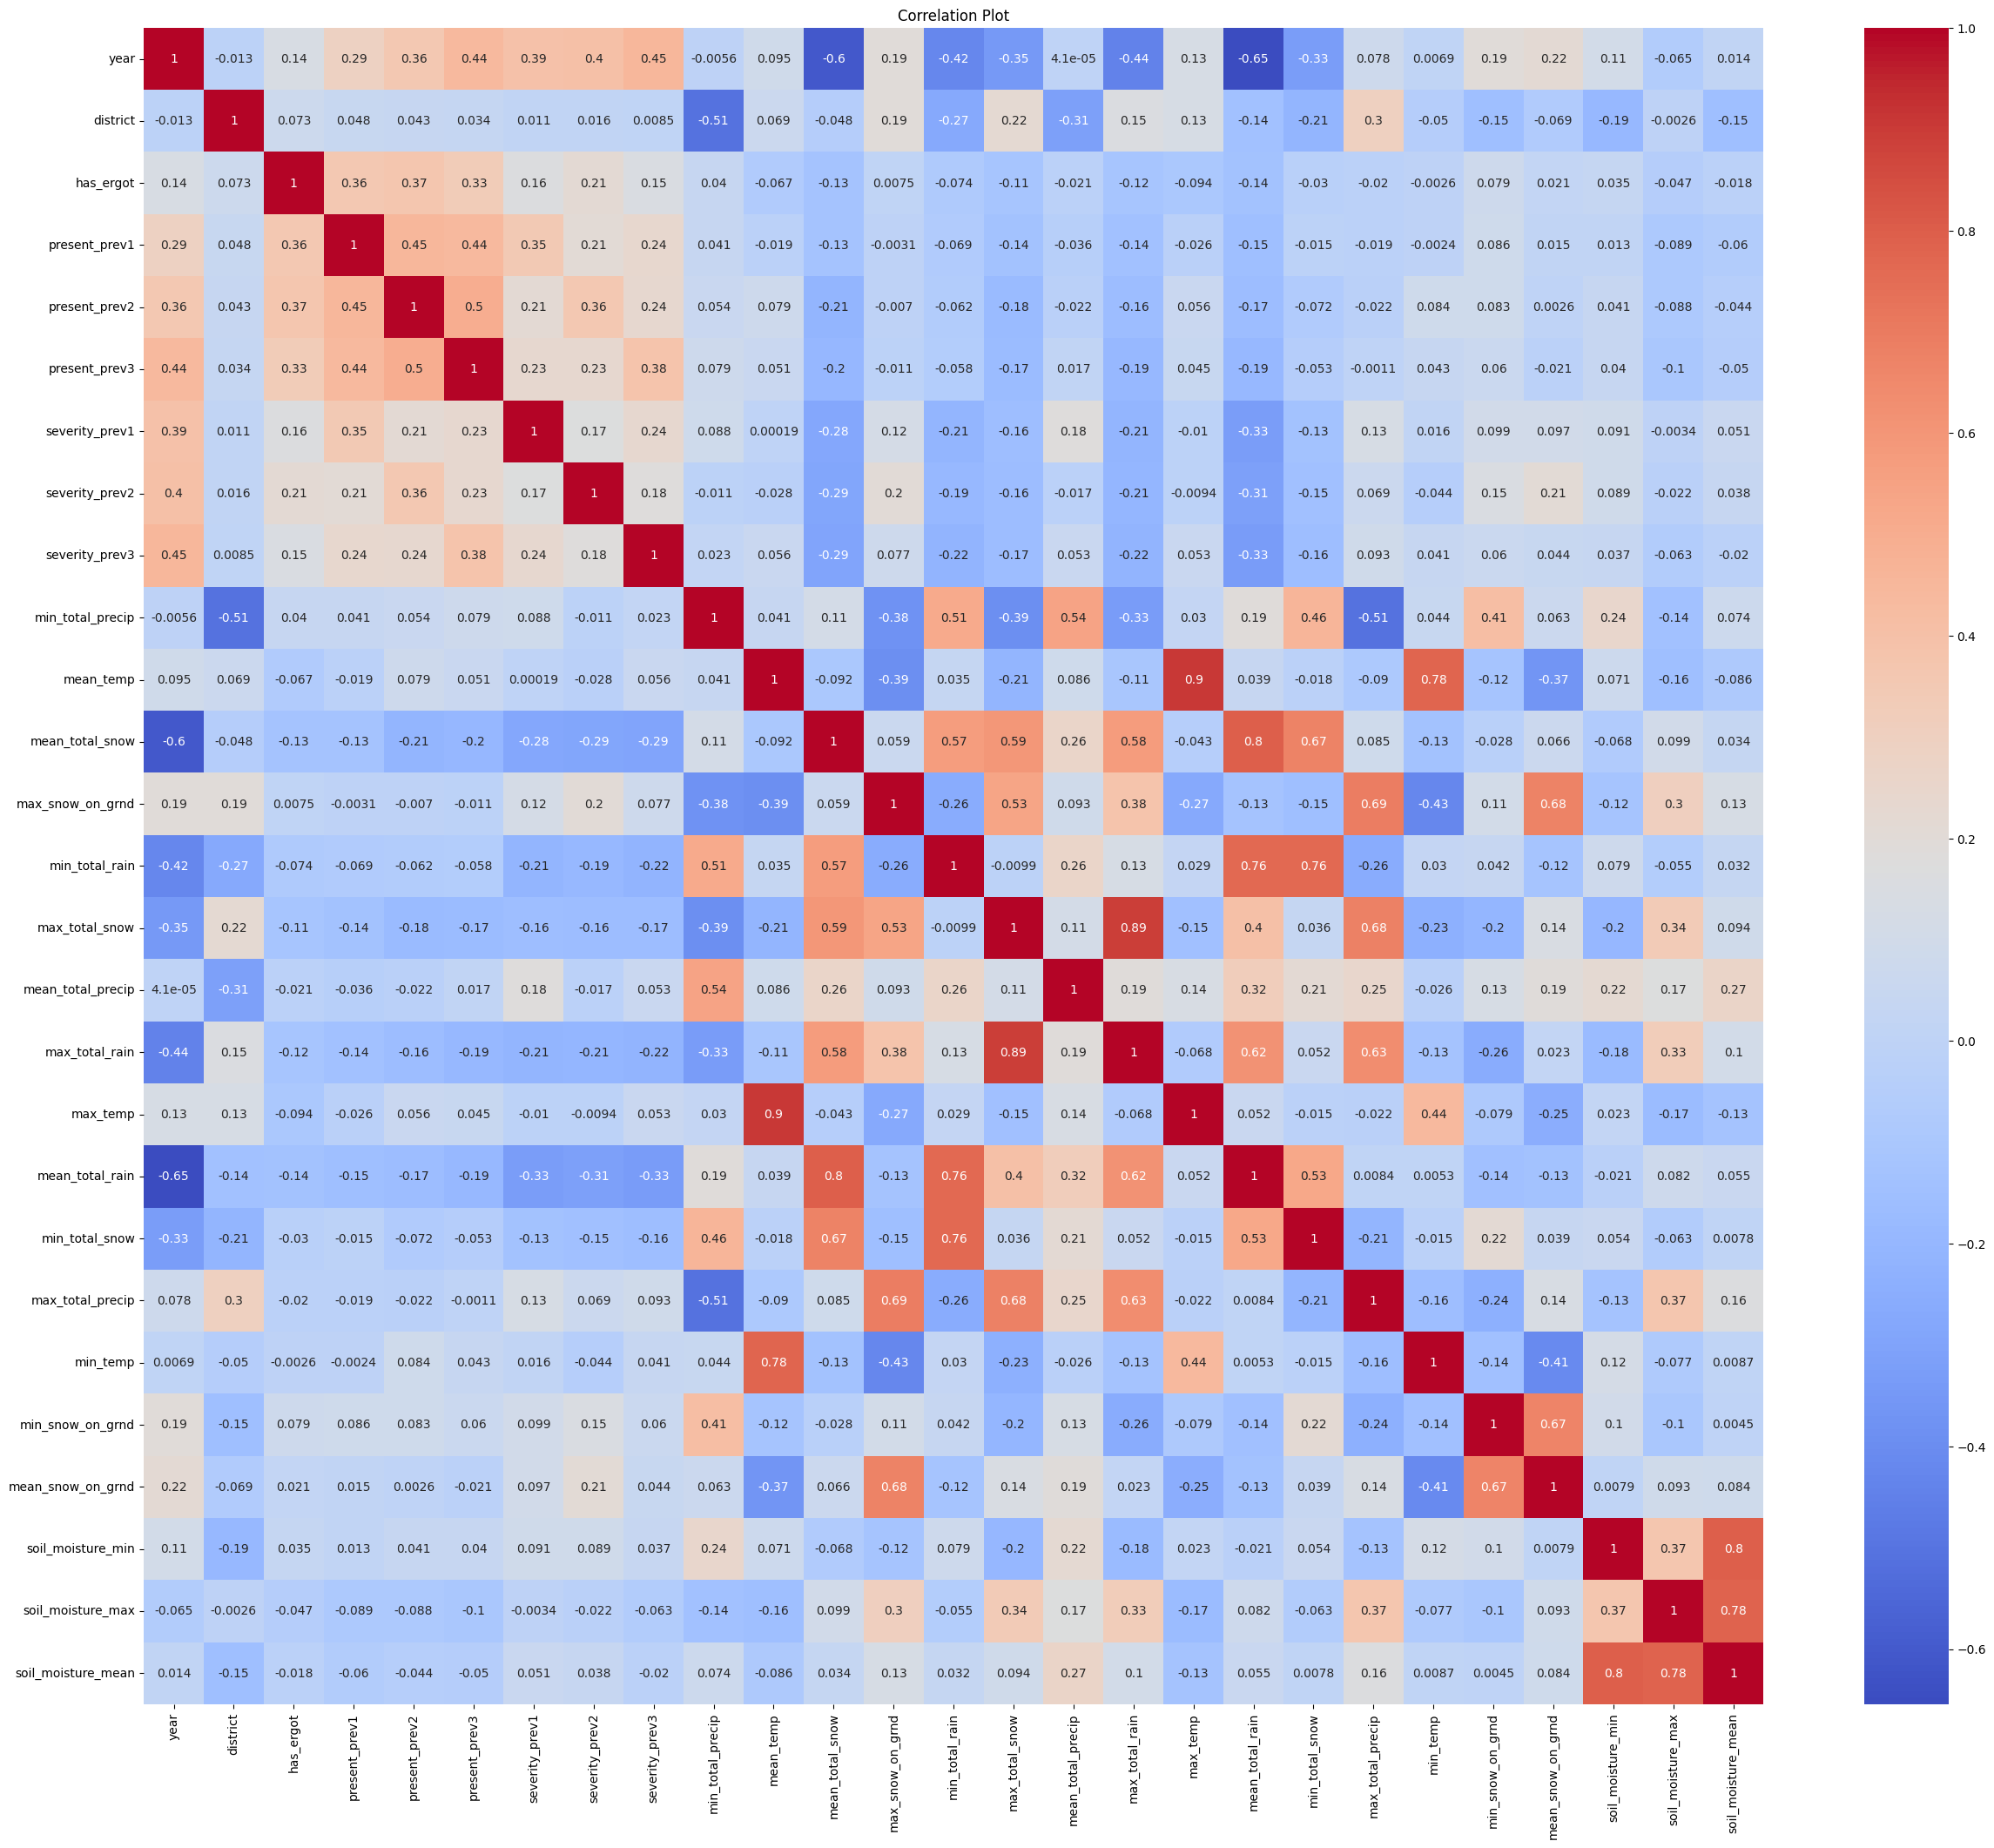

In [39]:
correlation_matrix = df.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

In [40]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [41]:
corr_features = correlation(df, 0.8)
len(set(corr_features))
corr_features

{'max_temp', 'max_total_rain'}

In [42]:
# df.drop(columns=corr_features, inplace=True)

In [43]:
# using one hot encoding to change catagorical variable to numarical
# df = pd.get_dummies(df, columns=["province"], drop_first=True)

In [64]:
df.drop(columns=["year", "district"], inplace=True)

In [65]:
df.columns

Index(['has_ergot', 'present_prev1', 'present_prev2', 'present_prev3',
       'severity_prev1', 'severity_prev2', 'severity_prev3',
       'min_total_precip', 'mean_temp', 'mean_total_snow', 'max_snow_on_grnd',
       'min_total_rain', 'max_total_snow', 'mean_total_precip',
       'max_total_rain', 'max_temp', 'mean_total_rain', 'min_total_snow',
       'max_total_precip', 'min_temp', 'min_snow_on_grnd', 'mean_snow_on_grnd',
       'soil_moisture_min', 'soil_moisture_max', 'soil_moisture_mean'],
      dtype='object')

# split data

In [66]:
X = df.drop(columns=["has_ergot"])
y = df['has_ergot']
oversampler = RandomOverSampler(random_state=42)
# y = df['has_ergot'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
# print(y_train.value_count())
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [67]:
X_train.columns

Index(['present_prev1', 'present_prev2', 'present_prev3', 'severity_prev1',
       'severity_prev2', 'severity_prev3', 'min_total_precip', 'mean_temp',
       'mean_total_snow', 'max_snow_on_grnd', 'min_total_rain',
       'max_total_snow', 'mean_total_precip', 'max_total_rain', 'max_temp',
       'mean_total_rain', 'min_total_snow', 'max_total_precip', 'min_temp',
       'min_snow_on_grnd', 'mean_snow_on_grnd', 'soil_moisture_min',
       'soil_moisture_max', 'soil_moisture_mean'],
      dtype='object')

In [68]:
# use StandardScaler when we don't know upper bounds
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
X_train_scaled.shape

(190836, 24)

In [70]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices


# creating model

In [84]:
model = Sequential()

model.add(Dense(15, activation="relu", input_dim = X.shape[1]))
# model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
# model.add(Dense(1, activation="sigmoid", input_dim = X.shape[1]))

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                375       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________


In [86]:
# compile model
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [87]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, shuffle=True, batch_size=32)

Epoch 1/50
4771/4771 [==============================] - 5s 901us/step - loss: 0.3507 - accuracy: 0.8483 - val_loss: 0.3081 - val_accuracy: 0.8680
Epoch 2/50
4771/4771 [==============================] - 4s 884us/step - loss: 0.2885 - accuracy: 0.8796 - val_loss: 0.2706 - val_accuracy: 0.8892
Epoch 3/50
4771/4771 [==============================] - 4s 908us/step - loss: 0.2610 - accuracy: 0.8931 - val_loss: 0.2502 - val_accuracy: 0.8973
Epoch 4/50
4771/4771 [==============================] - 4s 879us/step - loss: 0.2409 - accuracy: 0.9013 - val_loss: 0.2294 - val_accuracy: 0.9073
Epoch 5/50
4771/4771 [==============================] - 4s 891us/step - loss: 0.2208 - accuracy: 0.9123 - val_loss: 0.2103 - val_accuracy: 0.9168
Epoch 6/50
4771/4771 [==============================] - 4s 857us/step - loss: 0.2047 - accuracy: 0.9206 - val_loss: 0.1998 - val_accuracy: 0.9179
Epoch 7/50
4771/4771 [==============================] - 4s 903us/step - loss: 0.1927 - accuracy: 0.9256 - val_loss: 0.1869 -

In [88]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(24, 15) dtype=float32, numpy=
 array([[-4.88338679e-01, -4.58047241e-01,  1.30599618e-01,
          1.50667024e+00, -7.79719353e-02, -3.38622093e-01,
         -4.16383564e-01,  5.85044384e-01,  6.63182557e-01,
         -2.05365449e-01, -3.45788330e-01,  1.07243145e+00,
          6.01453558e-02, -5.22620916e-01,  1.15038228e+00],
        [-5.45362234e-01, -1.10281193e+00, -4.97552417e-02,
         -1.91421509e+00, -1.49678230e+00, -1.08008540e+00,
         -7.35055625e-01, -9.69515622e-01,  4.75135475e-01,
         -2.53701663e+00, -1.34887385e+00,  2.33838797e+00,
          1.11331391e+00, -1.88483453e+00,  2.75447750e+00],
        [ 2.02612892e-01,  1.20349371e+00,  1.40303224e-01,
          1.91069138e+00,  6.66221797e-01, -9.29000378e-01,
          1.49761647e-01,  1.54561257e+00,  7.02768028e-01,
         -2.96398282e-01, -9.56219316e-01, -8.49185705e-01,
         -1.44971430e+00,  1.12473273e+00, -5.29527247e-01],
        [-8.37861478e-01,  

In [89]:
y_pred = model.predict(X_test_scaled)

   1/1491 [..............................] - ETA: 38s

1491/1491 [==============================] - 1s 437us/step


In [90]:
threshhold = 0.8
y_pred = np.where(y_pred > threshhold, True, False)

# y_test = y_test.to_numpy()
# type(y_pred)

In [91]:
accuracy_score(y_test, y_pred)

0.9712213628455847

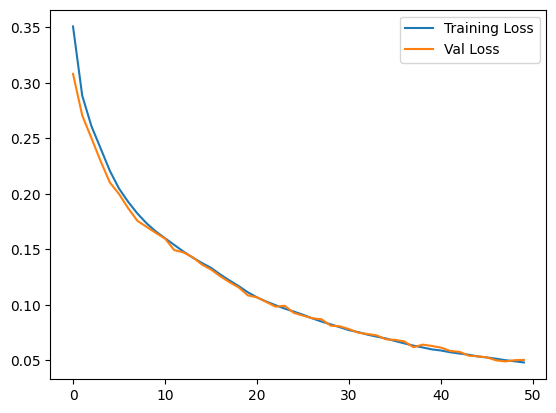

In [92]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()

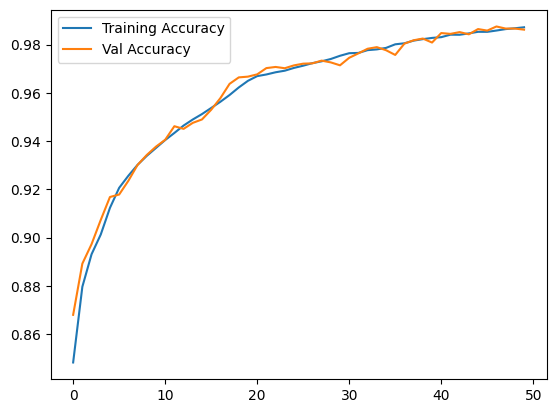

In [93]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.99      0.93      9661
        True       1.00      0.97      0.98     38048

    accuracy                           0.97     47709
   macro avg       0.94      0.98      0.96     47709
weighted avg       0.97      0.97      0.97     47709



0.979717437151827


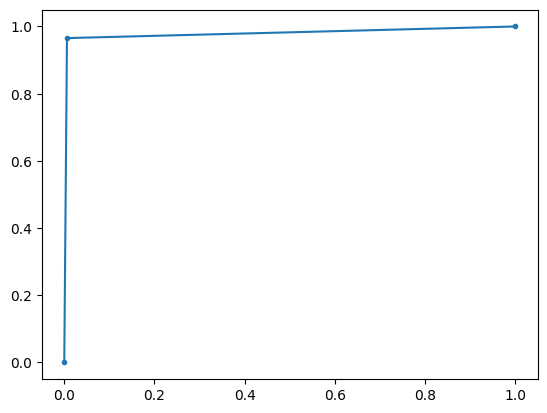

In [95]:
fpr, tpr, t = roc_curve(y_test, y_pred)
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr, marker=".")
print(auc_)

In [96]:
# prints weight with attribute
attributes = X_train.columns.tolist()
weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

result = {}

for x, y in zip(attributes, weights):
    result[x] = y

result = pd.DataFrame(result)

result.transpose()
print(result.max())

present_prev1         1.506670
present_prev2         2.754478
present_prev3         1.910691
severity_prev1        2.578181
severity_prev2        2.322416
severity_prev3        1.002985
min_total_precip      2.086574
mean_temp             1.014780
mean_total_snow       2.373800
max_snow_on_grnd      3.020520
min_total_rain        3.278202
max_total_snow        1.241137
mean_total_precip     1.883832
max_total_rain        2.874241
max_temp              1.287140
mean_total_rain       1.662910
min_total_snow        0.931874
max_total_precip      1.677577
min_temp              1.549327
min_snow_on_grnd      1.963937
mean_snow_on_grnd     3.312865
soil_moisture_min     0.062831
soil_moisture_max     0.038034
soil_moisture_mean    0.188511
dtype: float32
